### First set the size of the train/test set (they need to be equal)
And then run the entire notebook

In [ ]:
!pip install pymc3

In [1]:
nobs = 1000

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import log_loss as ll, roc_auc_score
import pymc3 as pm
from scipy.stats import entropy


import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import logistic
import seaborn as sns

np.random.seed(42)
plt.style.use('ggplot')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/asadagopan/miniconda/envs/mmath/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
clusters = {0: dict(prob = 0.2, w = -0.5,   # cluster weight in logistic
                    sites = np.arange(6),     
                    site_probs = [0.1, 0.1, 0.1, 0.1, 0.1, 0.5],
                    w_s =        [0.0, 0.0, 0.0, 5.0, 0.0, 0.0]),  # weights of sites in logistic
            1: dict(prob = 0.5, w = -1.0,  
                    sites = 6 + np.arange(3), 
                    site_probs = [0.1, 0.3, 0.6],
                    w_s        = [0.0, 0.0, 0.0]),                    
            2: dict(prob = 0.3, w = -0.2,  
                    sites = 9 + np.arange(3), 
                    site_probs = [0.3, 0.3, 0.4] ,
                    w_s =        [0.0, -4, 0.0 ]
                   )}


# num clusters
n_c = len(clusters)

# num sites
n_s = sum(list( map(len, list( map( lambda d: d['sites'], clusters.values()))))) # num sites

# site to cluster map
s2c = dict( [ (s,c) for c in range(n_c) for s in clusters[c]['sites']] )

# prob of each cluster occurring
p_c = [c['prob'] for c in clusters.values()]

# prob of site occurrence, within a cluster

p_s = ( [  dict( zip (d['sites'], d['site_probs']))  for d in clusters.values() ])

# "true" weights of clusters in logit model
w_c = np.array( [d['w'] for d in clusters.values()] )

# "true" weights of sites in logit model
w_s = np.concatenate( [d['w_s'] for d in clusters.values() ])

In [4]:

# logit for a site: sum of site-weight and its cluster-weight
def logit_site(site):
    return w_c[s2c[site]] + w_s[site]

# site response_rate
def rr_s(site):
    return logistic.cdf(logit_site(site))

In [5]:
def gen_prob_label(site):
    p = rr_s(site)
    return p, (np.random.uniform() < p)*1


def gen_row(cluster):
    site2prob = p_s[cluster]
    site_ids = list( site2prob.keys())
    probs = list(site2prob.values())
    site = site_ids[ np.random.choice(len(probs), 1, probs ) [0] ]
    prob, label = gen_prob_label(site)
    return [ cluster, site, prob, label ] 

def gen_data(N=100):
    clusters = np.random.choice(n_c, N, list(p_c))
    data = list(map(gen_row, clusters))
    df = pd.DataFrame( data, columns = ['cluster', 'site', 'prob', 'label'])
    features = dict(df[['cluster', 'site', 'prob']])
    labels = np.array(list( df['label']))
    return features, labels

def log_loss(labels, probs):
    return -np.mean(labels * np.log(probs) + (1-labels)*np.log(1-probs))

def rig(labels, probs):
    p = np.mean(labels)
    ent = -p*np.log(p) - (1-p)*np.log(1-p)
    loss = log_loss(labels, probs)
    return np.round(100*(ent - loss)/ent, 2)

# CAUTION: train, test size need to be same 
# because we hard-coded n_obs_train in the rand var defns below
x_train, y_train = gen_data(N=nobs)
x_test, y_test = gen_data(N=nobs)

c_train = x_train['cluster']
s_train = x_train['site']
n_obs_train = len(c_train)

c_test = x_test['cluster']
s_test = x_test['site']
n_obs_test = len(c_test)

def one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

def compute_probs_logistic(intercept, weights, x, dim_x):
    weights = np.squeeze(weights)
    logits = intercept + np.dot(one_hot(x,dim_x),weights)
    probs = expit(logits)
    return probs

def compute_probs_lme(intercept, weights, cluster_intercept, x, dim_x, cluster):
    weights = np.squeeze(weights)
    logits = intercept + np.dot(one_hot(x,dim_x),weights) + cluster_intercept.take(cluster)
    probs = expit(logits)
    return probs

In [6]:
rig_true=rig(y_test, x_test['prob'])
print(rig_true)

12.79


### MLE Logistic Model

In [7]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(fit_intercept=True)
lr.fit(one_hot(s_train, n_s), y_train)
mle_intercept = lr.intercept_
mle_weights = lr.coef_
probs_mle=compute_probs_logistic(mle_intercept, mle_weights, s_test, n_s)

In [8]:
print(mle_intercept)
print(mle_weights)

[-0.5731515]
[[-0.02302078 -0.13537729 -0.2130906   2.91451119 -0.07282496 -0.03494879
  -0.44820518 -0.21197196 -0.14644834  0.52546588 -2.90475641  0.17751573]]


In [9]:
rig_mle=rig(y_test, probs_mle)
print(rig_mle)

12.42


### Bayesian Logistic Model

In [10]:
with pm.Model() as bayesian_logistic:
    intercept = pm.Normal('intercept', mu=0, sd=1)
    w_s = pm.Normal('w_s', mu=0, sd=1, shape=n_s)
    logits = intercept + pm.math.dot(one_hot(s_train, n_s), w_s)
    probs = pm.Deterministic('probs',1 / (1 + pm.math.exp(-logits)))
    y_pred = pm.Bernoulli('y_pred', p=probs, observed=y_train)
    trace_logistic = pm.sample(5000,)
mcmc_chain = trace_logistic[100:]
varnames = ['intercept', 'w_s']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/asadagopan/miniconda/envs/mmath/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_s, intercept]
 50%|█████     | 2772/5500 [00:07<00:07, 387.69it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '38778' (I am process '38779')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/asadagopan/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '38778' (I am process '38780')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/asadagopan/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i38

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c241e74e0>,
      dtype=object)

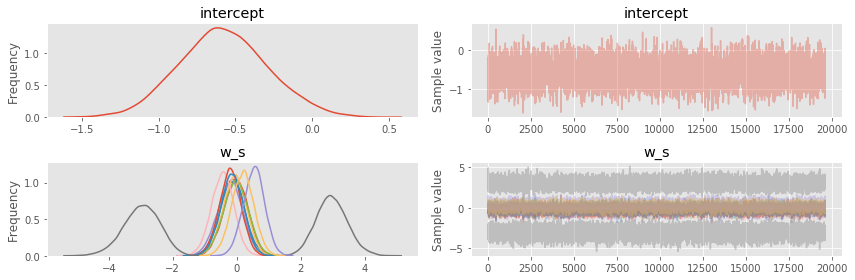

In [11]:
pm.traceplot(mcmc_chain, varnames=varnames,combined=True)

In [12]:
summary=pm.summary(mcmc_chain,varnames)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,-0.582441,0.289190,0.005577,-1.147657,-0.015480,2786.0,1.000283
w_s__0,-0.026054,0.374984,0.005861,-0.769183,0.687318,4527.0,1.000053
w_s__1,-0.137565,0.380327,0.005488,-0.924245,0.579707,4713.0,1.000033
w_s__2,-0.219018,0.388247,0.005638,-0.989028,0.521471,4953.0,1.000248
w_s__3,2.979683,0.486720,0.005999,2.007462,3.924618,7242.0,1.000122
w_s__4,-0.072530,0.364327,0.005871,-0.777910,0.647691,4035.0,1.000114
w_s__5,-0.035301,0.387785,0.005822,-0.811075,0.707589,4699.0,1.000008
w_s__6,-0.447042,0.347267,0.005815,-1.136067,0.226101,3827.0,1.000147
w_s__7,-0.210609,0.337654,0.005767,-0.871784,0.453669,3624.0,1.000211
w_s__8,-0.143986,0.353910,0.005979,-0.835731,0.546989,3877.0,1.000105


In [13]:
bayesian_intercept=summary['mean'][0]
bayesian_weights = summary['mean'][1:]

In [14]:
probs_bayes=compute_probs_logistic(bayesian_intercept, bayesian_weights, s_test, n_s)

In [15]:
rig_bayes=rig(y_test, probs_bayes)
print(rig_bayes)

12.43


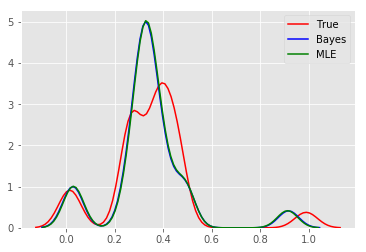

In [16]:
sns.kdeplot(x_test['prob'], color='red', label='True')
sns.kdeplot(probs_bayes,color='blue',label='Bayes')
sns.kdeplot(probs_mle, color='green', label='MLE')

### Bayes Mixed Effects

In [17]:
with pm.Model() as bayesian_lme:
    intercept = pm.Normal('intercept', mu=0, sd=1)
    w_s = pm.Normal('w_s', mu=0, sd=1, shape=n_s)
    w_c = pm.Normal('w_c', mu=0, sd=1, shape=n_c)
    logits = intercept + pm.math.dot(one_hot(s_train, n_s), w_s) + w_c[c_train]
    probs = pm.Deterministic('probs',1 / (1 + pm.math.exp(-logits)))
    y_pred = pm.Bernoulli('y_pred', p=probs, observed=y_train)
    trace_lme = pm.sample(5000,)
mcmc_chain_lme = trace_lme[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/asadagopan/miniconda/envs/mmath/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_c, w_s, intercept]
100%|██████████| 5500/5500 [02:59<00:00, 30.56it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24e123c8>,
      dtype=object)

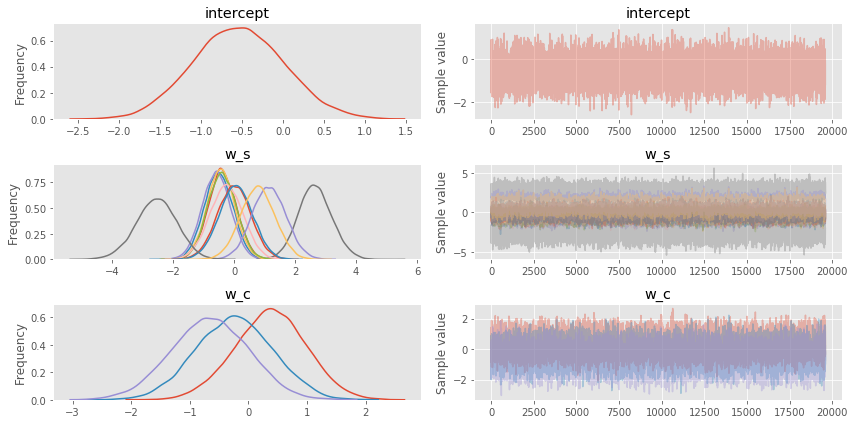

In [18]:
varnames_lme = ['intercept', 'w_s','w_c']
pm.traceplot(mcmc_chain_lme, varnames=varnames_lme,combined=True)

In [19]:
summary=pm.summary(mcmc_chain_lme,varnames_lme)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,-0.543185,0.553944,0.004483,-1.628973,0.535004,11779.0,1.000024
w_s__0,-0.400839,0.459276,0.004110,-1.293070,0.518714,10941.0,0.999925
w_s__1,-0.515727,0.461817,0.004065,-1.436375,0.364795,10658.0,0.999971
w_s__2,-0.590485,0.465625,0.003986,-1.495962,0.323953,11247.0,0.999962
w_s__3,2.659003,0.548570,0.004553,1.598495,3.754873,12932.0,0.999959
w_s__4,-0.453596,0.452442,0.003878,-1.332679,0.450871,10743.0,0.999979
w_s__5,-0.411103,0.468159,0.003806,-1.305184,0.515468,11154.0,0.999960
w_s__6,-0.258790,0.543880,0.005209,-1.326945,0.807336,12232.0,1.000173
w_s__7,-0.016633,0.543859,0.005037,-1.098288,1.036709,11846.0,1.000118
w_s__8,0.041389,0.548082,0.004886,-1.009595,1.140953,11972.0,1.000093


In [20]:
bayesian_lme_intercept=summary['mean'][0]
bayesian_lme_weights = summary['mean'][1:13]
lme_cluster_intercept = summary['mean'][13:]

In [21]:
probs_bayes_lme=compute_probs_lme(bayesian_lme_intercept, bayesian_lme_weights, lme_cluster_intercept,
                                  s_test, n_s, c_test)

In [22]:
rig_bayes_lme = rig(y_test, probs_bayes_lme)
rig_bayes_lme

12.58

### Test Probs

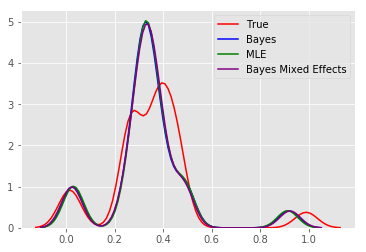

In [23]:
sns.kdeplot(x_test['prob'], color='red', label='True')
sns.kdeplot(probs_bayes,color='blue',label='Bayes')
sns.kdeplot(probs_mle, color='green', label='MLE')
sns.kdeplot(probs_bayes_lme, color='purple', label='Bayes Mixed Effects')

### RIG Comparison

In [24]:
print('Truth             :', rig_true)
print('MLE Logistic      :', rig_mle)
print('Bayesian Logistic :', rig_bayes)
print('Bayesian LME      :', rig_bayes_lme)

Truth             : 12.79
MLE Logistic      : 12.42
Bayesian Logistic : 12.43
Bayesian LME      : 12.58
